# Objective

This file explores different machine learning models to select the highest accuracy model for college football win predictions. The best model is saved to the output `cfb_model.joblib`.

## Import Libraries

In [42]:
# Data Manipulation
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Principle Component Analysis
from sklearn.decomposition import PCA

# Train Test Split
from sklearn.model_selection import train_test_split

# Classification Models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Accuracy Scoring
from sklearn.metrics import accuracy_score

# Grid Search Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Model Saving
import joblib

## Load Data

Loads and concatenates data from each year. Saved as `X` for feature space, `y` for outcome. 

In [43]:
X = pd.concat((pd.read_csv('data/X_2021.csv'), pd.read_csv('data/X_2022.csv'))).reset_index(drop=True)
y = pd.concat((pd.read_csv('data/y_2021.csv'), pd.read_csv('data/y_2022.csv'))).reset_index(drop=True)

## PCA

Principle component analysis performed to increase model performance. PCA fitted with `X` feature space. Explained variance ratios showed, with a clear elbow at PCA 8/9, indicating the use of 8-9 principle components. 

**Using PCA-transformed `X` feature space does not improve performance.**

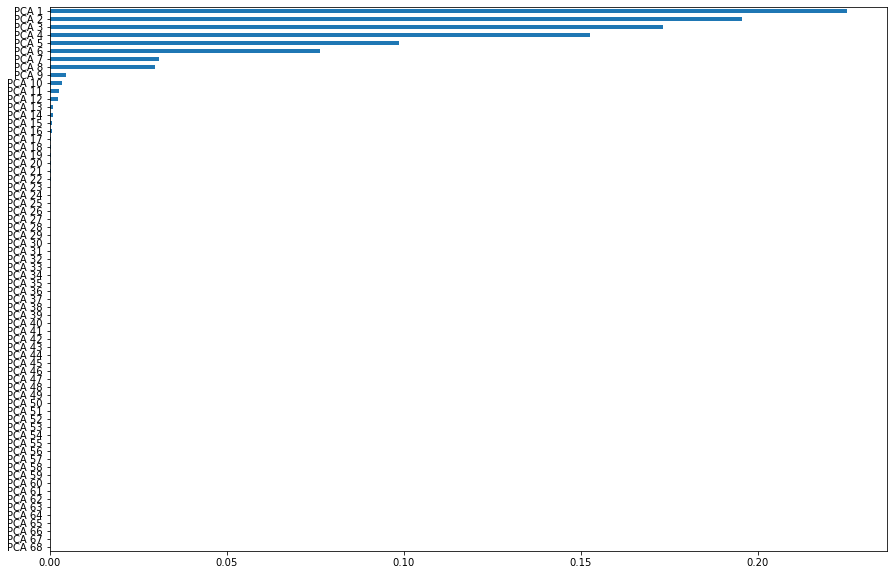

In [44]:
pca = PCA().fit(X)

pca_variances = pd.Series(pca.explained_variance_ratio_, index=[f'PCA {i}' for i in range(1, X.shape[1] + 1)]).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(15, 10))
pca_variances.plot(kind='barh', ax=ax)
plt.show()

## Training and Testing Data Split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Model Exploration

Several different classification models were used to determine the best (try all approach). 

The most accurate model was Logisitic Regression. 

In [47]:
models = {
	'Logistic Regression': LogisticRegression(),
	'Random Forest': RandomForestClassifier(),
	'KNN': KNeighborsClassifier(),
	'SVC': SVC(probability=True)
}

for name, model in models.items():
	model.fit(X_train, y_train['outcome'])
	print(f"{name}:  {round(accuracy_score(y_test['outcome'], model.predict(X_test)), 3)}")

Logistic Regression:  0.777
Random Forest:  0.742
KNN:  0.7
SVC:  0.749


## Hyper-Parameter Tuning

Tuning Logistic Regression model using grid search cross validation. Best model is saved as `clf` and exported to `cfb_model.joblib`.

In [48]:
lr_params = {
	'C': np.logspace(-3,3,7),
	'penalty': ['l1','l2'], 
    	'solver': ['newton-cg', 'lbfgs', 'liblinear']
}

grid = GridSearchCV(LogisticRegression(), lr_params, scoring='accuracy', cv=10)

grid.fit(X_train, y_train)

print(f"Best parameters for logistic regression: {grid.best_params_}")

clf = grid.best_estimator_

joblib.dump(clf, 'models/cfb_model.joblib')

Best parameters for logistic regression: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


['cfb_model.joblib']

## Feature Importances

To provide value to college football teams in terms of what they can control to change the outcome of a game, a feature importance chart was created using the random forest trained above. `rush_yds_home_def` (the average rushing yards the home team's defense allows per game) is the most imporant feature at the time of writing this.

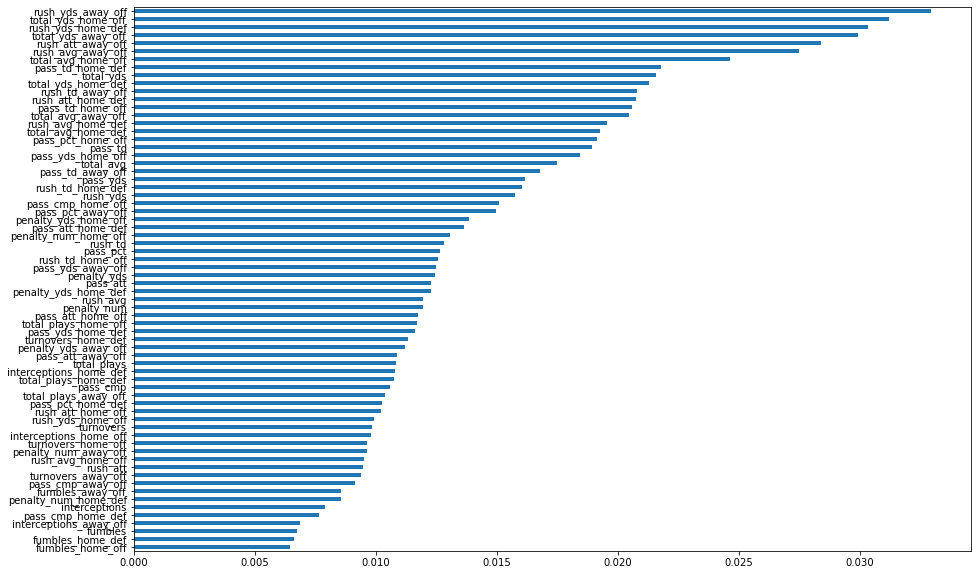

In [49]:
feature_importances = pd.Series(models['Random Forest'].feature_importances_, index=X.columns).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(15, 10))

feature_importances.plot(kind='barh', ax=ax)

plt.show()